# Importing Libraries

In [28]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D,Dropout,Flatten,MaxPooling2D,Input
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading dataset

In [29]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace'
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [30]:
# converting to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [31]:
# mapping labels for gender
gender_dict = {0:'Male', 1:'Female'}


# Exploratory Data Analysis(EDA)

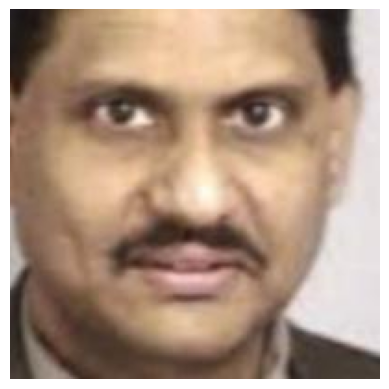

In [80]:
from PIL import Image
img = Image.open(df['image'][1000])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

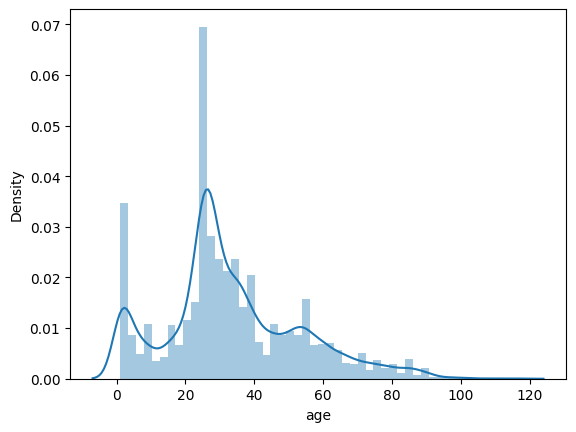

In [33]:
sns.distplot(df['age'])

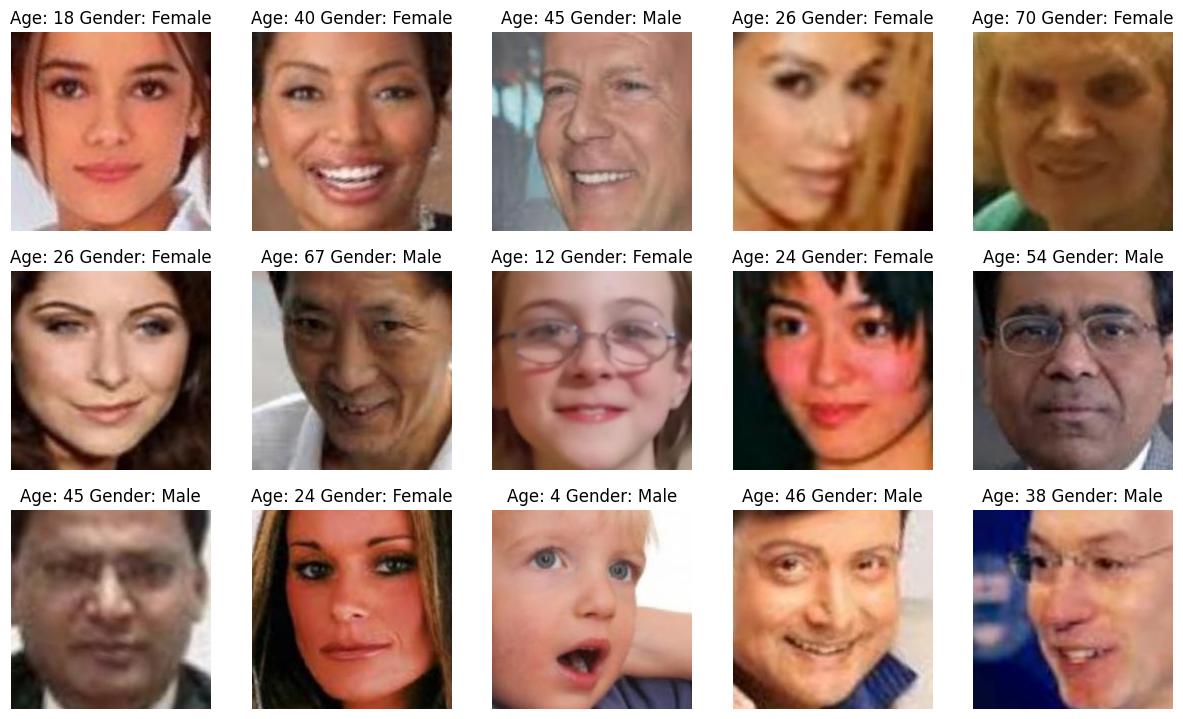

In [79]:
# to display grid of images
plt.figure(figsize=(15, 15))
files = df.iloc[10:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

# Feature Extraction

In [35]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features


In [36]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [37]:
X.shape

(23708, 128, 128, 1)

In [38]:
# normalize the images
X = X/255.0

In [39]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [40]:
input_shape = (128, 128, 1)

# Creating Training Model

In [41]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])


# Training Model

In [42]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
593/593 [==============================] - 412s 691ms/step - loss: 16.1302 - gender_out_loss: 0.6927 - age_out_loss: 15.4375 - gender_out_accuracy: 0.5283 - age_out_accuracy: 0.0475 - val_loss: 14.3597 - val_gender_out_loss: 0.6314 - val_age_out_loss: 13.7282 - val_gender_out_accuracy: 0.6887 - val_age_out_accuracy: 0.0462
Epoch 2/10
593/593 [==============================] - 423s 713ms/step - loss: 12.1157 - gender_out_loss: 0.5189 - age_out_loss: 11.5968 - gender_out_accuracy: 0.7459 - age_out_accuracy: 0.0391 - val_loss: 12.5084 - val_gender_out_loss: 0.4476 - val_age_out_loss: 12.0608 - val_gender_out_accuracy: 0.7889 - val_age_out_accuracy: 0.0424
Epoch 3/10
593/593 [==============================] - 407s 686ms/step - loss: 10.0510 - gender_out_loss: 0.4253 - age_out_loss: 9.6258 - gender_out_accuracy: 0.7995 - age_out_accuracy: 0.0220 - val_loss: 8.9179 - val_gender_out_loss: 0.3788 - val_age_out_loss: 8.5392 - val_gender_out_accuracy: 0.8296 - val_age_out_accuracy: 0.

# Plotting results

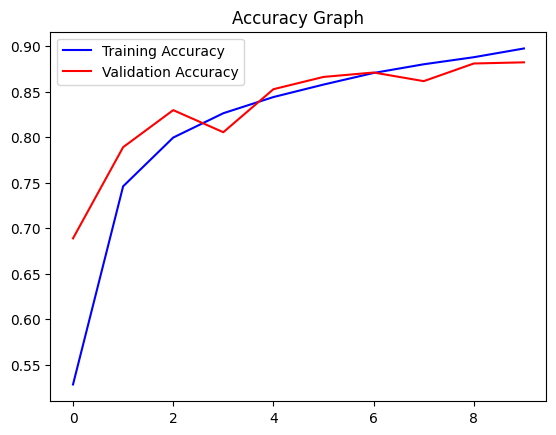

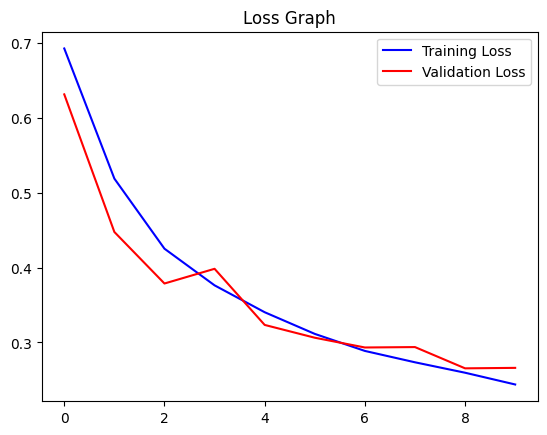

In [43]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

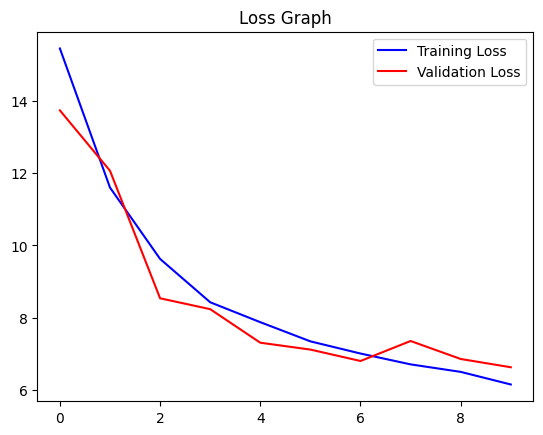

In [44]:
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Predictions

Original Gender: Male 
Original Age: 50
1/1 [==============================] - 0s 32ms/step
Predicted Gender: Male 
Predicted Age: 47


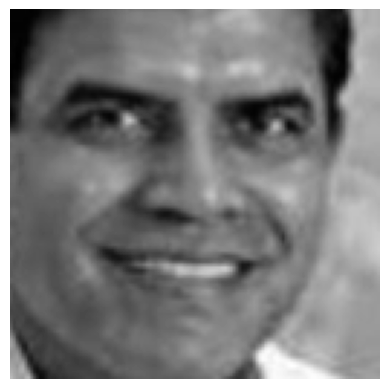

In [74]:
image_index = 999
print("Original Gender:", gender_dict[y_gender[image_index]], "\nOriginal Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')

Original Gender: Female 
Original Age: 26
1/1 [==============================] - 0s 33ms/step
Predicted Gender: Female 
Predicted Age: 26


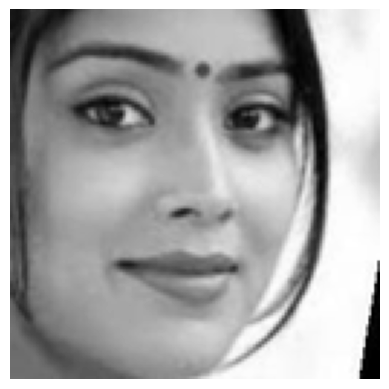

In [52]:
image_index = 5000
print("Original Gender:", gender_dict[y_gender[image_index]], "\nOriginal Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')

Original Gender: Male 
Original Age: 42
1/1 [==============================] - 0s 33ms/step
Predicted Gender: Male 
Predicted Age: 41


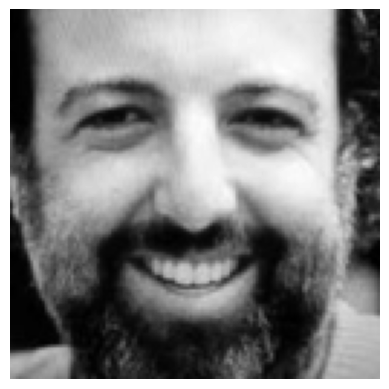

In [75]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "\nOriginal Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')